In [2]:
import pandas as pd
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [3]:
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)

c:\Users\tokud\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [4]:
filename = "FL_Reviews_Edited" + ".csv"
path = "C:/Users/tokud/OneDrive/Documents/Machine Learning - UCSD Extension Springboard Course/Capstone/Datasets/" + filename

chunk_iterator = pd.read_csv(path, chunksize=10000)

chunks = []

for chunk in chunk_iterator:
  chunks.append(chunk)

df_reviews = pd.concat(chunks, ignore_index=True)
df_reviews.shape

(792133, 24)

In [5]:
selected_fields = ['business_id', 'name', 'city_updated', 'stars_business', 'review_count', 'stars_reviews', 'text']

df_subset = df_reviews[selected_fields]
df_subset.head()

,business_id,name,city_updated,stars_business,review_count,stars_reviews,text
0,eEOYSgkmpB90uNA7lDOMRA,Vietnamese Food Truck,Tampa,4.0,10,5,"I eat pho about 4 times a week and from a specific restaurant, as I have tried just about every other Vietnamese restaurant in the Tampa bay area, and have found this specific one to be the best. After trying The Vietnamese Food Truck's Pho, for the first time today, I was absolutely blown away. It is the perfect balance of salty, savory and thai-basil infused flavor. Without a doubt, this is my new favorite place for pho."
1,eEOYSgkmpB90uNA7lDOMRA,Vietnamese Food Truck,Tampa,4.0,10,5,I've been in Wesley Chapel area for about 2 years and this is the first decent bowl of Pho I've had. Tampa is quite some distance to grab some. Being Vietnamese and growing up in the states I know how hard and labor intensive this is to make without a full on kitchen. This husband and wife team are amazingly sweet. I will definitely get an bowl every chance I get. I purchase it not assembled so please excuse my lack of sleep presentation skills!!!
2,eEOYSgkmpB90uNA7lDOMRA,Vietnamese Food Truck,Tampa,4.0,10,3,"Good tasted good - but I'm a bit confused as to how a Vietnamese Good trick serves Vietnamese egg rolls with a mayo-like sauce?? I love Vietnamese food, and have always had fish sauce as one of the condiments. The egg rolls on their own was ok, I even tried the mayo sauce - (not great). Next time - I'll stick with authentic Vietnamese restaurants. But to be fair, the food was standard . I'd actually try it again...if they had the right sauces, of course!"
3,eEOYSgkmpB90uNA7lDOMRA,Vietnamese Food Truck,Tampa,4.0,10,4,"Ordered the chicken wings. They were hot, fresh, and super crispy. Drenched in a honey sauce, that surprisingly, tasted good on the fries that came with the wings. Fantastic!"
4,eEOYSgkmpB90uNA7lDOMRA,Vietnamese Food Truck,Tampa,4.0,10,1,"How can an order of pho take an 1 hour and 15 minutes to make!!!!! No thank you. They had no system for getting the food out. People were flustered and they over sold on items. Terrible. Lesson learned. drive to pho Quyen, it will be faster and cheaper."


In [6]:
batch_size = 64

def batch_truncate_reviews(reviews):
    inputs = classifier.tokenizer(reviews, truncation=True, max_length=512, padding=True, return_tensors='pt')
    return inputs

truncated_reviews = []

for start in range(0, len(df_subset), batch_size):
    end = min(start + batch_size, len(df_subset))
    batch_reviews = df_subset['text'][start:end].tolist()
    inputs = batch_truncate_reviews(batch_reviews)
    truncated_reviews.extend(inputs['input_ids'])

df_subset['truncated_reviews'] = truncated_reviews

df_subset[['text', 'truncated_reviews']].head()

C:\Users\tokud\AppData\Local\Temp/ipykernel_25728/1121993432.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['truncated_reviews'] = truncated_reviews


,text,truncated_reviews
0,"I eat pho about 4 times a week and from a specific restaurant, as I have tried just about every other Vietnamese restaurant in the Tampa bay area, and have found this specific one to be the best. After trying The Vietnamese Food Truck's Pho, for the first time today, I was absolutely blown away. It is the perfect balance of salty, savory and thai-basil infused flavor. Without a doubt, this is my new favorite place for pho.","[tensor(101), tensor(151), tensor(39999), tensor(14061), tensor(10935), tensor(125), tensor(11471), tensor(143), tensor(14463), tensor(10110), tensor(10195), tensor(143), tensor(18974), tensor(21688), tensor(117), tensor(10146), tensor(151), tensor(10574), tensor(26806), tensor(12125), tensor(10935), tensor(13667), tensor(10675), tensor(55936), tensor(21688), tensor(10104), tensor(10103), tensor(36721), tensor(11836), tensor(10793), tensor(117), tensor(10110), tensor(10574), tensor(11973), tensor(10372), tensor(18974), tensor(10399), tensor(10114), tensor(10346), tensor(10103), tensor(11146), tensor(119), tensor(10515), tensor(30517), tensor(10103), tensor(55936), tensor(15225), tensor(38325), tensor(112), tensor(161), tensor(14061), tensor(117), tensor(10139), tensor(10103), tensor(10403), tensor(10573), tensor(13980), tensor(117), tensor(151), tensor(10140), tensor(35925), tensor(10563), tensor(50368), tensor(10115), tensor(13795), tensor(119), tensor(10197), tensor(10127), tensor(10103), tensor(23021), tensor(31117), tensor(10108), tensor(20474), tensor(10158), tensor(117), tensor(21026), tensor(11160), tensor(10110), tensor(14224), tensor(118), tensor(55415), tensor(56551), tensor(36538), tensor(19341), tensor(27553), tensor(10131), tensor(119), tensor(13208), tensor(143), tensor(55572), tensor(117), tensor(10372), tensor(10127), tensor(11153), tensor(10246), tensor(35380), tensor(11125), tensor(10139), tensor(14061), tensor(119), ...]"
1,I've been in Wesley Chapel area for about 2 years and this is the first decent bowl of Pho I've had. Tampa is quite some distance to grab some. Being Vietnamese and growing up in the states I know how hard and labor intensive this is to make without a full on kitchen. This husband and wife team are amazingly sweet. I will definitely get an bowl every chance I get. I purchase it not assembled so please excuse my lack of sleep presentation skills!!!,"[tensor(101), tensor(151), tensor(112), tensor(10312), tensor(10662), tensor(10104), tensor(35859), tensor(24916), tensor(10793), tensor(10139), tensor(10935), tensor(123), tensor(10868), tensor(10110), tensor(10372), tensor(10127), tensor(10103), tensor(10403), tensor(32937), tensor(11604), tensor(21170), tensor(10108), tensor(14061), tensor(151), tensor(112), tensor(10312), tensor(10407), tensor(119), tensor(36721), tensor(10127), tensor(29977), tensor(10970), tensor(17631), tensor(10114), tensor(50470), tensor(10970), tensor(119), tensor(11352), tensor(55936), tensor(10110), tensor(23148), tensor(10700), tensor(10104), tensor(10103), tensor(10821), tensor(151), tensor(16332), tensor(12548), tensor(15282), tensor(10110), tensor(19106), tensor(62422), tensor(10372), tensor(10127), tensor(10114), tensor(12696), tensor(13208), tensor(143), tensor(12851), tensor(10125), tensor(43954), tensor(119), tensor(10372), tensor(19137), tensor(10110), tensor(14131), tensor(10820), tensor(10320), tensor(39854), tensor(10563), tensor(19355), tensor(119), tensor(151), tensor(11229), tensor(69923), tensor(27393), tensor(13168), tensor(10144), tensor(21170), tensor(13667), tensor(20035), tensor(151), tensor(13168), tensor(119), tensor(151), tensor(33831), tensor(10197), tensor(10497), tensor(78863), tensor(10297), tensor(38881), tensor(11460), tensor(14112), tensor(10111), tensor(11153), tensor(23051), tensor(10108), tensor(32524), tensor(33289), tensor(30504), ...]"
2,"Good tasted good - but I'm a bit confused as to how a Vietnamese Good trick serves Vietnamese egg rolls with a mayo-like sauce?? I love Vietnamese

In [7]:
batch_size = 64
decoded_reviews = []

for start in range(0, len(df_subset), batch_size):
    end = min(start + batch_size, len(df_subset))
    batch_token_ids = df_subset['truncated_reviews'][start:end].tolist()
    
    batch_decoded = [tokenizer.decode(token_ids, skip_special_tokens=True) for token_ids in batch_token_ids]
    decoded_reviews.extend(batch_decoded)

df_subset['decoded_reviews'] = decoded_reviews

df_subset[['text', 'truncated_reviews', 'decoded_reviews']].head()

C:\Users\tokud\AppData\Local\Temp/ipykernel_25728/3745662519.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['decoded_reviews'] = decoded_reviews


,text,truncated_reviews,decoded_reviews
0,"I eat pho about 4 times a week and from a specific restaurant, as I have tried just about every other Vietnamese restaurant in the Tampa bay area, and have found this specific one to be the best. After trying The Vietnamese Food Truck's Pho, for the first time today, I was absolutely blown away. It is the perfect balance of salty, savory and thai-basil infused flavor. Without a doubt, this is my new favorite place for pho.","[tensor(101), tensor(151), tensor(39999), tensor(14061), tensor(10935), tensor(125), tensor(11471), tensor(143), tensor(14463), tensor(10110), tensor(10195), tensor(143), tensor(18974), tensor(21688), tensor(117), tensor(10146), tensor(151), tensor(10574), tensor(26806), tensor(12125), tensor(10935), tensor(13667), tensor(10675), tensor(55936), tensor(21688), tensor(10104), tensor(10103), tensor(36721), tensor(11836), tensor(10793), tensor(117), tensor(10110), tensor(10574), tensor(11973), tensor(10372), tensor(18974), tensor(10399), tensor(10114), tensor(10346), tensor(10103), tensor(11146), tensor(119), tensor(10515), tensor(30517), tensor(10103), tensor(55936), tensor(15225), tensor(38325), tensor(112), tensor(161), tensor(14061), tensor(117), tensor(10139), tensor(10103), tensor(10403), tensor(10573), tensor(13980), tensor(117), tensor(151), tensor(10140), tensor(35925), tensor(10563), tensor(50368), tensor(10115), tensor(13795), tensor(119), tensor(10197), tensor(10127), tensor(10103), tensor(23021), tensor(31117), tensor(10108), tensor(20474), tensor(10158), tensor(117), tensor(21026), tensor(11160), tensor(10110), tensor(14224), tensor(118), tensor(55415), tensor(56551), tensor(36538), tensor(19341), tensor(27553), tensor(10131), tensor(119), tensor(13208), tensor(143), tensor(55572), tensor(117), tensor(10372), tensor(10127), tensor(11153), tensor(10246), tensor(35380), tensor(11125), tensor(10139), tensor(14061), tensor(119), ...]","i eat pho about 4 times a week and from a specific restaurant, as i have tried just about every other vietnamese restaurant in the tampa bay area, and have found this specific one to be the best. after trying the vietnamese food truck's pho, for the first time today, i was absolutely blown away. it is the perfect balance of salty, savory and thai - basil infused flavor. without a doubt, this is my new favorite place for pho."
1,I've been in Wesley Chapel area for about 2 years and this is the first decent bowl of Pho I've had. Tampa is quite some distance to grab some. Being Vietnamese and growing up in the states I know how hard and labor intensive this is to make without a full on kitchen. This husband and wife team are amazingly sweet. I will definitely get an bowl every chance I get. I purchase it not assembled so please excuse my lack of sleep presentation skills!!!,"[tensor(101), tensor(151), tensor(112), tensor(10312), tensor(10662), tensor(10104), tensor(35859), tensor(24916), tensor(10793), tensor(10139), tensor(10935), tensor(123), tensor(10868), tensor(10110), tensor(10372), tensor(10127), tensor(10103), tensor(10403), tensor(32937), tensor(11604), tensor(21170), tensor(10108), tensor(14061), tensor(151), tensor(112), tensor(10312), tensor(10407), tensor(119), tensor(36721), tensor(10127), tensor(29977), tensor(10970), tensor(17631), tensor(10114), tensor(50470), tensor(10970), tensor(119), tensor(11352), tensor(55936), tensor(10110), tensor(23148), tensor(10700), tensor(10104), tensor(10103), tensor(10821), tensor(151), tensor(16332), tensor(12548), tensor(15282), tensor(10110), tensor(19106), tensor(62422), tensor(10372), tensor(10127), tensor(10114), tensor(12696), tensor(13208), tensor(143), tensor(12851), tensor(10125), tensor(43954), tensor(119), tensor(10372), tensor(19137), tensor(10110), tensor(14131), tensor(10820), tensor(10320), tensor(39854), tensor(10563), tensor(19355), tensor(119), tensor(151), tensor(11229), tensor(69923), tensor(27393), tensor(13168), tensor(10144), tensor(21170), tensor(13667), te

In [8]:
columns_to_drop = ['truncated_reviews']

df_subset.drop(columns=columns_to_drop, inplace=True)
df_subset.columns

c:\Users\tokud\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Index(['business_id', 'name', 'city_updated', 'stars_business', 'review_count',
       'stars_reviews', 'text', 'decoded_reviews'],
      dtype='object')

In [9]:
filename = "decoded_yelp_reviews" + ".csv"
out_path = "C:/Users/tokud/OneDrive/Documents/Machine Learning - UCSD Extension Springboard Course/Capstone/Datasets/" + filename

df_subset.to_csv(out_path, index=False)

In [24]:
percentage = 0.0025

# df_sample = df_subset.sample(frac=percentage, random_state=42)

df_sample = df_subset[df_subset['stars_reviews'].isin([1,5])]
df_sample = df_sample.sample(frac=percentage, random_state=42)

df_sample.shape

(1186, 8)

In [25]:
predicted_star_ratings = []

batch_size = 128

for start in range(0, len(df_sample), batch_size):
    end = min(start + batch_size, len(df_sample))
    
    batch_reviews = df_sample['decoded_reviews'][start:end].tolist()

    batch_predictions = classifier(batch_reviews)
    
    batch_ratings = [int(pred['label'][0]) for pred in batch_predictions]
    predicted_star_ratings.extend(batch_ratings)
    
    # print(f"Processed batch {start // batch_size + 1} of {len(df_sample) // batch_size + 1}")

    if start // batch_size % 5 == 0:
        print(f"Processed batch {start // batch_size + 1} of {len(df_sample) // batch_size + 1}")


df_sample['predicted_star_rating'] = predicted_star_ratings

Processed batch 1 of 10
Processed batch 6 of 10


In [26]:
df_sample.columns

Index(['business_id', 'name', 'city_updated', 'stars_business', 'review_count',
       'stars_reviews', 'text', 'decoded_reviews', 'predicted_star_rating'],
      dtype='object')

In [27]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(df_sample['stars_reviews'], df_sample['predicted_star_rating'])
print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 0.3077571669477234


In [28]:
accuracy = (df_sample['stars_reviews'] == df_sample['predicted_star_rating']).mean()
print("Accuracy:", accuracy)

Accuracy: 0.7765598650927488


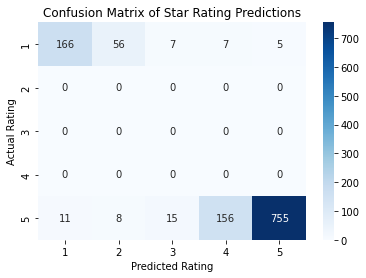

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(df_sample['stars_reviews'], df_sample['predicted_star_rating'])
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
plt.xlabel("Predicted Rating")
plt.ylabel("Actual Rating")
plt.title("Confusion Matrix of Star Rating Predictions")
plt.show()

In [31]:
one_predicted_ratings = df_sample[df_sample['predicted_star_rating'] == 5]
one_predicted_ratings = one_predicted_ratings[one_predicted_ratings['stars_reviews'] == 1]
one_predicted_ratings[0:11]

,business_id,name,city_updated,stars_business,review_count,stars_reviews,text,decoded_reviews,predicted_star_rating
131172,emKtu_pZ-Oij9dXra8tXYg,Oak & Stone - St. Petersburg,Saint Petersburg,4.0,447,1,"ICE COLD PIZZA LIVES HERE!\n\nDon't get the GF Greek! It comes out refrigerator COLD!! I mean raw, crisp red onion, semi-frozen feta, crunchy red peppers and spinach.\nLiterally like a cold salad on top of the crust! \n\nI asked for them to warm it up and it came out cold AGAIN!!! Then the waiter said,"" it was just how they did it, it was their creative take on it"". All this and if you ask for roasted garlic (or anything) they charge you $2.00 for like six cloves.","ice cold pizza lives here! don't get the gf greek! it comes out refrigerator cold!! i mean raw, crisp red onion, semi - frozen feta, crunchy red peppers and spinach. literally like a cold salad on top of the crust! i asked for them to warm it up and it came out cold again!!! then the waiter said, "" it was just how they did it, it was their creative take on it "". all this and if you ask for roasted garlic ( or anything ) they charge you $ 2. 00 for like six cloves.",5
743115,uhkd7al0Z4FV7MtDNRXnlA,Rubio's Coastal Grill,Tampa,4.0,231,1,"This has been one of my favorite places for take out and has never disappointed me until today. Ordered a Mango Avo Salad for myself and a Chipotle Orange Salad Bowl with additional proteins. The staff informed me after I paid and ordered that they were out of Mango for my salad and they said they'd put oranges instead per my request. Upon getting home 25 minutes away, my salad bowl consisted of - and I kid you not- Greens, a few tortilla strips, and 3 mandarin orange slices. Was missing avocado, missing the brown rice, and missing the quinoa (the reason I chose this bowl). The other bowl- Chipotle Orange (my girlfriend chose bc she was craving your elotes corn) did not contain any corn. $30 for two salad bowls is a splurge and is totally worth it if all the ingredients find there way in there. Not sure what happened tonight. We will not be returning.","this has been one of my favorite places for take out and has never disappointed me until today. ordered a mango avo salad for myself and a chipotle orange salad bowl with additional proteins. the staff informed me after i paid and ordered that they were out of mango for my salad and they said they'd put oranges instead per my request. upon getting home 25 minutes away, my salad bowl consisted of - and i kid you not - greens, a few tortilla strips, and 3 mandarin orange slices. was missing avocado, missing the brown rice, and missing the quinoa ( the reason i chose this bowl ). the other bowl - chipotle orange ( my girlfriend chose bc she was craving your elotes corn ) did not contain any corn. $ 30 for two salad bowls is a splurge and is totally worth it if all the ingredients find there way in there. not sure what happened tonight. we will not be returning.",5
710408,uFu73KlTXu9fonjMkMwYvQ,Luke's Sports Shack Bar & Grill,Largo,3.5,65,1,Went to The Sports Shack tonight and sat in a booth with my two teenage kiddos. Sat there for 5 minutes while the waitresses chit chatted with the bartender off and on while glancing at us! We got up to leave and still nothing...didn't even notice we came and went. That's a great location to open a restaurant!,went to the sports shack tonight and sat in a booth with my two teenage kiddos. sat there for 5 minutes while the waitresses chit chatted with the bartender off and on while glancing at us! we got up to leave and still nothing... didn't even notice we came and went. that's a great location to open a restaurant!,5
419819,NJ6unjwQCbCEmurnFllnMQ,Little Caesars Pizza,Tampa,2.0,7,1,NASTY!! Drove all the way to this location to get the pizza I grew up on in Michigan only to have a hair in the crust!!,nasty!! drove all the way to this location to get the pizza i grew up on in michigan only to have a hair in the crust!!,5
593317,5Y4HAjtn0c0TY0aX4XME6w,